# Projet de Data Mining

## Import des librairies et des fichiers

In [1]:
import os
import torch
import joblib
import matplotlib


from mpp.utils.data_processing import DataProcessor
from mpp.utils.model_utils import train_and_evaluate_models
from mpp.models.neural_network import NeuralNetworkModel
from mpp.models.random_forest import RandomForestModel
from mpp.models.gradient_boosting import GradientBoostingModel
from mpp.models.knn import BaselineKNN
from mpp.utils.visualization import plot_correlation_matrix, plot_results, plot_training_process, plot_multiple_training_processes, plot_feature_correlations
from mpp.tuning.tune import HyperparameterTuning

import warnings
warnings.filterwarnings('ignore')

# make figures appear inline
matplotlib.rcParams['figure.figsize'] = (15, 8)
%matplotlib inline

# notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

---
## Initialisation

In [2]:
# use cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


Fonction qui vérifie si un fichier existe.

In [3]:
def model_exists(model_path):
    return os.path.exists(model_path)

In [4]:
# Load the data
processor = DataProcessor("data/data.csv")
data = processor.load_data()
data_with_features = processor.extract_features()
print(data_with_features)

       pIC50  num_atoms     logP    MolWt  NumAtoms  NumBonds  NumC  NumO  \
0       4.26         25  4.15910  367.455        25        28     0     2   
1       4.34         36  3.67430  506.434        36        40     2     4   
2       4.53         23  1.53610  317.389        23        25    10     3   
3       4.56         22  0.95100  301.394        22        24     9     1   
4       4.59         21  3.21300  294.383        21        23     2     0   
...      ...        ...      ...      ...       ...       ...   ...   ...   
15032   0.00         24  3.21560  333.420        24        26     2     0   
15033   0.00         19  5.45270  275.461        19        19    11     0   
15034   0.00         17  4.67250  247.407        17        17     9     0   
15035   0.00         22  3.93289  306.394        22        25     1     0   
15036   0.02         13  1.70887  181.131        13        13     2     2   

       NumN  NumCl  NumF  NumBr  NumI  
0         1      0     0      0    

In [5]:
# Split the data
X_train, X_test, y_train_pic50, y_test_pic50, y_train_logP, y_test_logP = processor.split_data()

---
## Matrice de corrélation

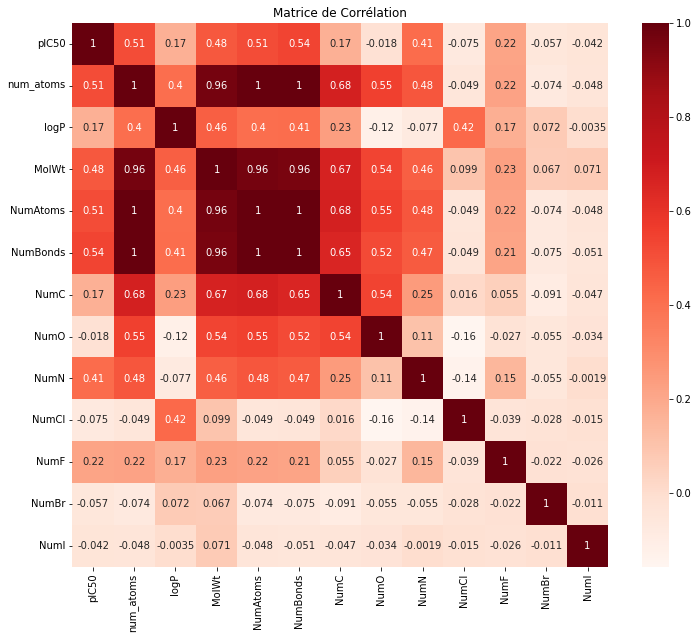

In [6]:
# Feature visualization
plot_correlation_matrix(data_with_features)

### Affichage des corrélations

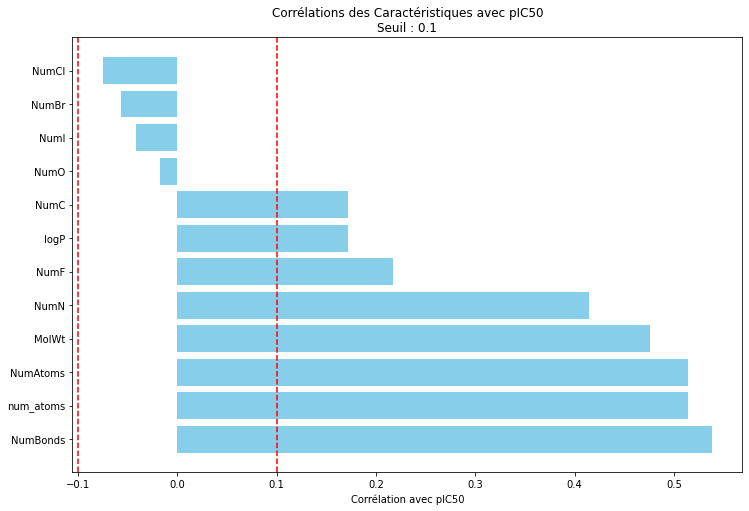

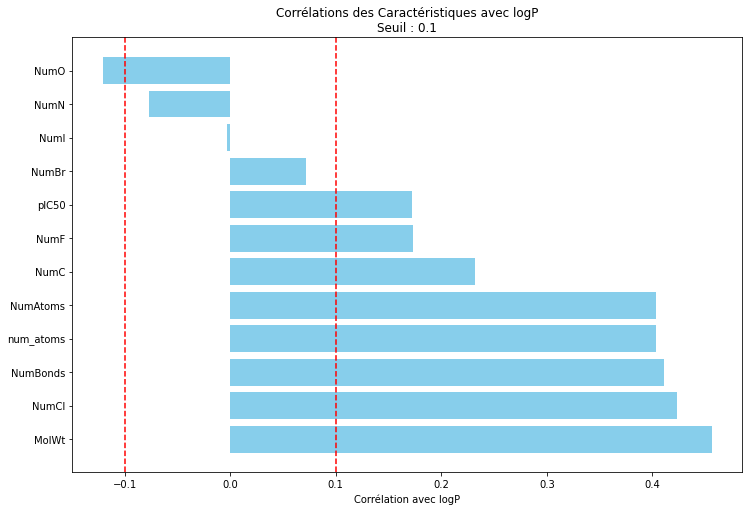

In [7]:
# Plot feature correlations with pIC50 and logP
plot_feature_correlations(data_with_features, 'pIC50', output_path="feature_correlations_pic50.png")
plot_feature_correlations(data_with_features, 'logP', output_path="feature_correlations_logP.png")

---
## Réseau de neurones

### pic50

Loaded existing pIC50 params.

Best trial : {'lr': 0.0021666814143117574, 'epochs': 87, 'batch_size': 121, 'hidden_layers': 3, 'hidden_size_0': 54, 'hidden_size_1': 73, 'hidden_size_2': 115, 'patience': 11}



Neural Network Model MSE for pIC50: 1.162891762183362
Neural Network Model RMSE for pIC50: 1.0783745927011459
Neural Network Model MAE for pIC50: 0.439398436761917
Neural Network Model MAPE for pIC50: 421488137366770.6


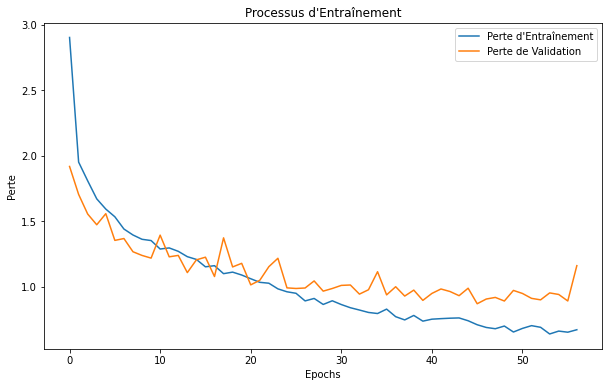

In [16]:
# Hyperparameter tuning for Neural Network (pIC50)
if model_exists('params/nn_best_params_pic50.pkl'):
    print("Loaded existing pIC50 params.\n")
    loaded_best_params_pic50 = joblib.load('params/nn_best_params_pic50.pkl')
    print(f"Best trial : {loaded_best_params_pic50}")
    nn_model_pic50 = NeuralNetworkModel(
        input_size=X_train.shape[1],
        hidden_sizes=[loaded_best_params_pic50[f"hidden_size_{i}"] for i in range(loaded_best_params_pic50["hidden_layers"])],
        lr=loaded_best_params_pic50["lr"],
        epochs=loaded_best_params_pic50["epochs"],
        batch_size=loaded_best_params_pic50["batch_size"],
        patience=loaded_best_params_pic50["patience"]
    )
    training_loss_pic50, validation_loss_pic50 = nn_model_pic50.train(X_train, y_train_pic50, X_test, y_test_pic50)
    nn_mse_pIC50, nn_rmse_pIC50, nn_mae_pIC50, nn_mape_pIC50 = nn_model_pic50.evaluate(X_test, y_test_pic50)
    print(f"Neural Network Model MSE for pIC50: {nn_mse_pIC50}")
    print(f"Neural Network Model RMSE for pIC50: {nn_rmse_pIC50}")
    print(f"Neural Network Model MAE for pIC50: {nn_mae_pIC50}")
    print(f"Neural Network Model MAPE for pIC50: {nn_mape_pIC50}")
    plot_training_process(training_loss_pic50, validation_loss_pic50, output_path="training_process_pic50.png")
else:
    tuner_pic50 = HyperparameterTuning(X_train, y_train_pic50, "Neural Network")
    best_params_pic50 = tuner_pic50.tune(n_trials=50)
    joblib.dump(best_params_pic50, 'params/nn_best_params_pic50.pkl')
    nn_model_pic50 = NeuralNetworkModel(
        input_size=X_train.shape[1],
        hidden_sizes=[best_params_pic50[f"hidden_size_{i}"] for i in range(best_params_pic50["hidden_layers"])],
        lr=best_params_pic50["lr"],
        epochs=best_params_pic50["epochs"],
        batch_size=best_params_pic50["batch_size"],
        patience=best_params_pic50["patience"]
    )
    training_loss_pic50, validation_loss_pic50 = nn_model_pic50.train(X_train, y_train_pic50, X_test, y_test_pic50)
    nn_mse_pIC50, nn_rmse_pIC50, nn_mae_pIC50, nn_mape_pIC50 = nn_model_pic50.evaluate(X_test, y_test_pic50)
    print(f"Neural Network Model MSE for pIC50: {nn_mse_pIC50}")
    print(f"Neural Network Model RMSE for pIC50: {nn_rmse_pIC50}")
    print(f"Neural Network Model MAE for pIC50: {nn_mae_pIC50}")
    print(f"Neural Network Model MAPE for pIC50: {nn_mape_pIC50}")
    plot_training_process(training_loss_pic50, validation_loss_pic50, output_path="training_process_pic50.png")


### logP

Loaded existing logP params.

Best trial : {'lr': 0.0056863426884850195, 'epochs': 99, 'batch_size': 96, 'hidden_layers': 3, 'hidden_size_0': 135, 'hidden_size_1': 183, 'hidden_size_2': 164, 'patience': 16}



Neural Network Model MSE for logP: 0.3992015412786383
Neural Network Model RMSE for logP: 0.6318239796641453
Neural Network Model MAE for logP: 0.46970922452111186
Neural Network Model MAPE for logP: 0.6860632743852406


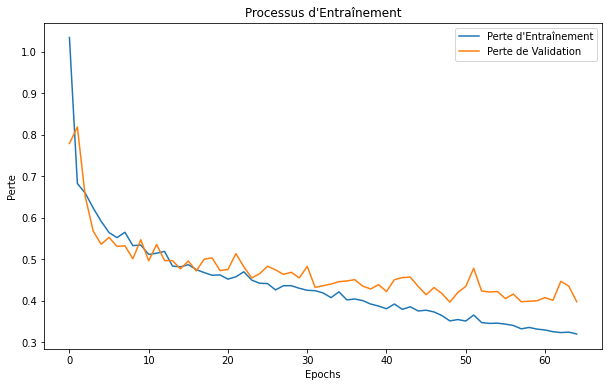

In [18]:
# Hyperparameter tuning for Neural Network (logP)
if model_exists('params/nn_best_params_logP.pkl'):
    print("Loaded existing logP params.\n")
    loaded_best_params_logP = joblib.load('params/nn_best_params_logP.pkl')
    print(f"Best trial : {loaded_best_params_logP}")
    nn_model_logP = NeuralNetworkModel(
        input_size=X_train.shape[1],
        hidden_sizes=[loaded_best_params_logP[f"hidden_size_{i}"] for i in range(loaded_best_params_logP["hidden_layers"])],
        lr=loaded_best_params_logP["lr"],
        epochs=loaded_best_params_logP["epochs"],
        batch_size=loaded_best_params_logP["batch_size"],
        patience=loaded_best_params_logP["patience"]
    )
    training_loss_logP, validation_loss_logP = nn_model_logP.train(X_train, y_train_logP, X_test, y_test_logP)
    nn_mse_logP, nn_rmse_logP, nn_mae_logP, nn_mape_logP = nn_model_logP.evaluate(X_test, y_test_logP)
    print(f"Neural Network Model MSE for logP: {nn_mse_logP}")
    print(f"Neural Network Model RMSE for logP: {nn_rmse_logP}")
    print(f"Neural Network Model MAE for logP: {nn_mae_logP}")
    print(f"Neural Network Model MAPE for logP: {nn_mape_logP}")
    plot_training_process(training_loss_logP, validation_loss_logP, output_path="training_process_logP.png")
else:
    tuner_logP = HyperparameterTuning(X_train, y_train_logP, "Neural Network")
    best_params_logP = tuner_logP.tune(n_trials=50)
    joblib.dump(best_params_logP, 'params/nn_best_params_logP.pkl')
    nn_model_logP = NeuralNetworkModel(
        input_size=X_train.shape[1],
        hidden_sizes=[best_params_logP[f"hidden_size_{i}"] for i in range(best_params_logP["hidden_layers"])],
        lr=best_params_logP["lr"],
        epochs=best_params_logP["epochs"],
        batch_size=best_params_logP["batch_size"],
        patience=best_params_logP["patience"]
    )
    training_loss_logP, validation_loss_logP = nn_model_logP.train(X_train, y_train_logP, X_test, y_test_logP)
    torch.save(nn_model_logP.model.state_dict(), 'models/nn_model_logP.pth')
    nn_mse_logP, nn_rmse_logP, nn_mae_logP, nn_mape_logP = nn_model_logP.evaluate(X_test, y_test_logP)
    print(f"Neural Network Model MSE for logP: {nn_mse_logP}")
    print(f"Neural Network Model RMSE for logP: {nn_rmse_logP}")
    print(f"Neural Network Model MAE for logP: {nn_mae_logP}")
    print(f"Neural Network Model MAPE for logP: {nn_mape_logP}")
    plot_training_process(training_loss_logP, validation_loss_logP, output_path="training_process_logP.png")


---
## K-nearest neighbors (KNN)

### pic50

In [19]:
# Hyperparameter tuning and model training for KNN (pIC50)
if model_exists('params/knn_best_params_pic50.pkl'):
    print("Loaded existing pIC50 KNN params.\n")
    loaded_best_params_pic50_knn = joblib.load('params/knn_best_params_pic50.pkl')
    print(f"Best trial : {loaded_best_params_pic50_knn}")
    knn_model_pic50 = BaselineKNN(n_neighbors=loaded_best_params_pic50_knn["n_neighbors"])
    knn_model_pic50.train(X_train, y_train_pic50)
    knn_mse_pic50, knn_rmse_pic50, knn_mae_pic50, knn_mape_pic50 = knn_model_pic50.evaluate(X_test, y_test_pic50)
    print(f"KNN Model MSE for pIC50: {knn_mse_pic50}")
    print(f"KNN Model RMSE for pIC50: {knn_rmse_pic50}")
    print(f"KNN Model MAE for pIC50: {knn_mae_pic50}")
    print(f"KNN Model MAPE for pIC50: {knn_mape_pic50}")
else:
    tuner_pic50_knn = HyperparameterTuning(X_train, y_train_pic50, "KNN")
    best_params_pic50_knn = tuner_pic50_knn.tune(n_trials=50)
    joblib.dump(best_params_pic50_knn, 'params/knn_best_params_pic50.pkl')
    knn_model_pic50 = BaselineKNN(n_neighbors=best_params_pic50_knn["n_neighbors"])
    knn_model_pic50.train(X_train, y_train_pic50)
    knn_mse_pic50, knn_rmse_pic50, knn_mae_pic50, knn_mape_pic50 = knn_model_pic50.evaluate(X_test, y_test_pic50)
    print(f"KNN Model MSE for pIC50: {knn_mse_pic50}")
    print(f"KNN Model RMSE for pIC50: {knn_rmse_pic50}")
    print(f"KNN Model MAE for pIC50: {knn_mae_pic50}")
    print(f"KNN Model MAPE for pIC50: {knn_mape_pic50}")


Loaded existing pIC50 KNN params.

Best trial : {'n_neighbors': 3}
KNN Model MSE for pIC50: 1.7327211768617021
KNN Model RMSE for pIC50: 1.3163286735696758
KNN Model MAE for pIC50: 0.4647994237588653
KNN Model MAPE for pIC50: 733521793031541.6


### logP

In [20]:
# Hyperparameter tuning and model training for KNN (logP)
if model_exists('params/knn_best_params_logP.pkl'):
    print("Loaded existing logP KNN params.\n")
    loaded_best_params_logP_knn = joblib.load('params/knn_best_params_logP.pkl')
    print(f"Best trial : {loaded_best_params_logP_knn}")
    knn_model_logP = BaselineKNN(n_neighbors=loaded_best_params_logP_knn["n_neighbors"])
    knn_model_logP.train(X_train, y_train_logP)
    knn_mse_logP, knn_rmse_logP, knn_mae_logP, knn_mape_logP = knn_model_logP.evaluate(X_test, y_test_logP)
    print(f"KNN Model MSE for logP: {knn_mse_logP}")
    print(f"KNN Model RMSE for logP: {knn_rmse_logP}")
    print(f"KNN Model MAE for logP: {knn_mae_logP}")
    print(f"KNN Model MAPE for logP: {knn_mape_logP}")
else:
    tuner_logP_knn = HyperparameterTuning(X_train, y_train_logP, "KNN")
    best_params_logP_knn = tuner_logP_knn.tune(n_trials=50)
    joblib.dump(best_params_logP_knn, 'params/knn_best_params_logP.pkl')
    knn_model_logP = BaselineKNN(n_neighbors=best_params_logP_knn["n_neighbors"])
    knn_model_logP.train(X_train, y_train_logP)
    knn_mse_logP, knn_rmse_logP, knn_mae_logP, knn_mape_logP = knn_model_logP.evaluate(X_test, y_test_logP)
    print(f"KNN Model MSE for logP: {knn_mse_logP}")
    print(f"KNN Model RMSE for logP: {knn_rmse_logP}")
    print(f"KNN Model MAE for logP: {knn_mae_logP}")
    print(f"KNN Model MAPE for logP: {knn_mape_logP}")

Loaded existing logP KNN params.

Best trial : {'n_neighbors': 4}
KNN Model MSE for logP: 0.7276687296320423
KNN Model RMSE for logP: 0.8530350107891482
KNN Model MAE for logP: 0.6084029097406916
KNN Model MAPE for logP: 0.8202455604966713


---
## Random Forest

### pic50

In [21]:
# Hyperparameter tuning and model training for Random Forest (pIC50)
if model_exists('params/rf_best_params_pic50.pkl'):
    print("Loaded existing pIC50 Random Forest params.\n")
    loaded_best_params_pic50_rf = joblib.load('params/rf_best_params_pic50.pkl')
    print(f"Best trial : {loaded_best_params_pic50_rf}")
    rf_model_pic50 = RandomForestModel(n_estimators=loaded_best_params_pic50_rf["n_estimators"], 
                                       max_depth=loaded_best_params_pic50_rf["max_depth"])
    rf_model_pic50.train(X_train, y_train_pic50)
    rf_mse_pic50, rf_rmse_pic50, rf_mae_pic50, rf_mape_pic50 = rf_model_pic50.evaluate(X_test, y_test_pic50)
    print(f"Random Forest Model MSE for pIC50: {rf_mse_pic50}")
    print(f"Random Forest Model RMSE for pIC50: {rf_rmse_pic50}")
    print(f"Random Forest Model MAE for pIC50: {rf_mae_pic50}")
    print(f"Random Forest Model MAPE for pIC50: {rf_mape_pic50}")
else:
    tuner_pic50_rf = HyperparameterTuning(X_train, y_train_pic50, "Random Forest")
    best_params_pic50_rf = tuner_pic50_rf.tune(n_trials=50)
    joblib.dump(best_params_pic50_rf, 'params/rf_best_params_pic50.pkl')
    rf_model_pic50 = RandomForestModel(n_estimators=best_params_pic50_rf["n_estimators"], 
                                       max_depth=best_params_pic50_rf["max_depth"])
    rf_model_pic50.train(X_train, y_train_pic50)
    rf_mse_pic50, rf_rmse_pic50, rf_mae_pic50, rf_mape_pic50 = rf_model_pic50.evaluate(X_test, y_test_pic50)
    print(f"Random Forest Model MSE for pIC50: {rf_mse_pic50}")
    print(f"Random Forest Model RMSE for pIC50: {rf_rmse_pic50}")
    print(f"Random Forest Model MAE for pIC50: {rf_mae_pic50}")
    print(f"Random Forest Model MAPE for pIC50: {rf_mape_pic50}")


Loaded existing pIC50 Random Forest params.

Best trial : {'n_estimators': 192, 'max_depth': 27}
Random Forest Model MSE for pIC50: 1.0019969717995072
Random Forest Model RMSE for pIC50: 1.0009979879098194
Random Forest Model MAE for pIC50: 0.3590496253487973
Random Forest Model MAPE for pIC50: 512828287089534.44


### logP

In [22]:
# Hyperparameter tuning and model training for Random Forest (logP)
if model_exists('params/rf_best_params_logP.pkl'):
    print("Loaded existing logP Random Forest params.\n")
    loaded_best_params_logP_rf = joblib.load('params/rf_best_params_logP.pkl')
    print(f"Best trial : {loaded_best_params_logP_rf}")
    rf_model_logP = RandomForestModel(n_estimators=loaded_best_params_logP_rf["n_estimators"], max_depth=loaded_best_params_logP_rf["max_depth"])
    rf_model_logP.train(X_train, y_train_logP)
    rf_mse_logP, rf_rmse_logP, rf_mae_logP, rf_mape_logP = rf_model_logP.evaluate(X_test, y_test_logP)
    print(f"Random Forest Model MSE for logP: {rf_mse_logP}")
    print(f"Random Forest Model RMSE for logP: {rf_rmse_logP}")
    print(f"Random Forest Model MAE for logP: {rf_mae_logP}")
    print(f"Random Forest Model MAPE for logP: {rf_mape_logP}")
else:
    tuner_logP_rf = HyperparameterTuning(X_train, y_train_logP, "Random Forest")
    best_params_logP_rf = tuner_logP_rf.tune(n_trials=50)
    joblib.dump(best_params_logP_rf, 'params/rf_best_params_logP.pkl')
    rf_model_logP = RandomForestModel(n_estimators=best_params_logP_rf["n_estimators"], max_depth=best_params_logP_rf["max_depth"])
    rf_model_logP.train(X_train, y_train_logP)
    rf_mse_logP, rf_rmse_logP, rf_mae_logP, rf_mape_logP = rf_model_logP.evaluate(X_test, y_test_logP)
    print(f"Random Forest Model MSE for logP: {rf_mse_logP}")
    print(f"Random Forest Model RMSE for logP: {rf_rmse_logP}")
    print(f"Random Forest Model MAE for logP: {rf_mae_logP}")
    print(f"Random Forest Model MAPE for logP: {rf_mape_logP}")


Loaded existing logP Random Forest params.

Best trial : {'n_estimators': 127, 'max_depth': 24}
Random Forest Model MSE for logP: 0.43847171947963387
Random Forest Model RMSE for logP: 0.6621719712277422
Random Forest Model MAE for logP: 0.45356593117766153
Random Forest Model MAPE for logP: 0.6241401635655568


---
## Gradient Boosting

### pic50

In [13]:
# Hyperparameter tuning and model training for Gradient Boosting (pIC50)
if model_exists('params/gb_best_params_pic50.pkl'):
    print("Loaded existing pIC50 Gradient Boosting params.\n")
    loaded_best_params_pic50_gb = joblib.load('params/gb_best_params_pic50.pkl')
    print(f"Best trial : {loaded_best_params_pic50_gb}")
    gb_model_pic50 = GradientBoostingModel(n_estimators=loaded_best_params_pic50_gb["n_estimators"], 
                                           learning_rate=loaded_best_params_pic50_gb["learning_rate"], 
                                           max_depth=loaded_best_params_pic50_gb["max_depth"])
    gb_model_pic50.train(X_train, y_train_pic50)
    gb_mse_pIC50, gb_rmse_pIC50, gb_mae_pIC50, gb_mape_pIC50 = gb_model_pic50.evaluate(X_test, y_test_pic50)
    print(f"Gradient Boosting Model MSE for pIC50: {gb_mse_pIC50}")
    print(f"Gradient Boosting Model RMSE for pIC50: {gb_rmse_pIC50}")
    print(f"Gradient Boosting Model MAE for pIC50: {gb_mae_pIC50}")
    print(f"Gradient Boosting Model MAPE for pIC50: {gb_mape_pIC50}")
else:
    tuner_pic50_gb = HyperparameterTuning(X_train, y_train_pic50, "Gradient Boosting")
    best_params_pic50_gb = tuner_pic50_gb.tune(n_trials=50)
    joblib.dump(best_params_pic50_gb, 'params/gb_best_params_pic50.pkl')
    gb_model_pic50 = GradientBoostingModel(n_estimators=best_params_pic50_gb["n_estimators"], 
                                           learning_rate=best_params_pic50_gb["learning_rate"], 
                                           max_depth=best_params_pic50_gb["max_depth"])
    gb_model_pic50.train(X_train, y_train_pic50)
    gb_mse_pIC50, gb_rmse_pIC50, gb_mae_pIC50, gb_mape_pIC50 = gb_model_pic50.evaluate(X_test, y_test_pic50)
    print(f"Gradient Boosting Model MSE for pIC50: {gb_mse_pIC50}")
    print(f"Gradient Boosting Model RMSE for pIC50: {gb_rmse_pIC50}")
    print(f"Gradient Boosting Model MAE for pIC50: {gb_mae_pIC50}")
    print(f"Gradient Boosting Model MAPE for pIC50: {gb_mape_pIC50}")


Loaded existing pIC50 Gradient Boosting params.

Best trial : {'n_estimators': 173, 'learning_rate': 0.020746793365614725, 'max_depth': 10}
Gradient Boosting Model MSE for pIC50: 1.0737869511194111
Gradient Boosting Model RMSE for pIC50: 1.0362369184310174
Gradient Boosting Model MAE for pIC50: 0.37423913969883654
Gradient Boosting Model MAPE for pIC50: 525481110354704.3


### logP

In [23]:
# Hyperparameter tuning and model training for Gradient Boosting (logP)
if model_exists('params/gb_best_params_logP.pkl'):
    print("Loaded existing logP Gradient Boosting params.\n")
    loaded_best_params_logP_gb = joblib.load('params/gb_best_params_logP.pkl')
    print(f"Best trial : {loaded_best_params_logP_gb}")
    gb_model_logP = GradientBoostingModel(n_estimators=loaded_best_params_logP_gb["n_estimators"], 
                                          learning_rate=loaded_best_params_logP_gb["learning_rate"], 
                                          max_depth=loaded_best_params_logP_gb["max_depth"])
    gb_model_logP.train(X_train, y_train_logP)
    gb_mse_logP, gb_rmse_logP, gb_mae_logP, gb_mape_logP = gb_model_logP.evaluate(X_test, y_test_logP)
    print(f"Gradient Boosting Model MSE for logP: {gb_mse_logP}")
    print(f"Gradient Boosting Model RMSE for logP: {gb_rmse_logP}")
    print(f"Gradient Boosting Model MAE for logP: {gb_mae_logP}")
    print(f"Gradient Boosting Model MAPE for logP: {gb_mape_logP}")
else:
    tuner_logP_gb = HyperparameterTuning(X_train, y_train_logP, "Gradient Boosting")
    best_params_logP_gb = tuner_logP_gb.tune(n_trials=50)
    joblib.dump(best_params_logP_gb, 'params/gb_best_params_logP.pkl')
    gb_model_logP = GradientBoostingModel(n_estimators=best_params_logP_gb["n_estimators"], 
                                          learning_rate=best_params_logP_gb["learning_rate"], 
                                          max_depth=best_params_logP_gb["max_depth"])
    gb_model_logP.train(X_train, y_train_logP)
    gb_mse_logP, gb_rmse_logP, gb_mae_logP, gb_mape_logP = gb_model_logP.evaluate(X_test, y_test_logP)
    print(f"Gradient Boosting Model MSE for logP: {gb_mse_logP}")
    print(f"Gradient Boosting Model RMSE for logP: {gb_rmse_logP}")
    print(f"Gradient Boosting Model MAE for logP: {gb_mae_logP}")
    print(f"Gradient Boosting Model MAPE for logP: {gb_mape_logP}")


Loaded existing logP Gradient Boosting params.

Best trial : {'n_estimators': 155, 'learning_rate': 0.057744771357231404, 'max_depth': 10}
Gradient Boosting Model MSE for logP: 0.43403599947085886
Gradient Boosting Model RMSE for logP: 0.658814085665189
Gradient Boosting Model MAE for logP: 0.47073933702996856
Gradient Boosting Model MAPE for logP: 0.6701762692431266


---
## Dictionnaires des calculs d'erreur

### pic50

In [34]:
# Results visualization for pIC50
results_pic50_mse = {
    "Neural Network": nn_mse_pIC50,
    "KNN": knn_mse_pic50,
    "Random Forest": rf_mse_pic50,
    "Gradient Boosting": gb_mse_pIC50
}

results_pic50_rmse = {
    "Neural Network": nn_rmse_pIC50,
    "KNN": knn_rmse_pic50,
    "Random Forest": rf_rmse_pic50,
    "Gradient Boosting": gb_rmse_pIC50
}

results_pic50_mae = {
    "Neural Network": nn_mae_pIC50,
    "KNN": knn_mae_pic50,
    "Random Forest": rf_mae_pic50,
    "Gradient Boosting": gb_mae_pIC50
}

results_pic50_mape = {
    "Neural Network": nn_mae_pIC50,
    "KNN": knn_mape_pic50,
    "Random Forest": rf_mape_pic50,
    "Gradient Boosting": gb_mape_pIC50
}

### logP

In [35]:
# Results visualization for logP
results_logP_mse = {
    "Neural Network": nn_mse_logP,
    "KNN": knn_mse_logP,
    "Random Forest": rf_mse_logP,
    "Gradient Boosting": gb_mse_logP
}

results_logP_rmse = {
    "Neural Network": nn_rmse_logP,
    "KNN": knn_rmse_logP,
    "Random Forest": rf_rmse_logP,
    "Gradient Boosting": gb_rmse_logP
}

results_logP_mae = {
    "Neural Network": nn_mae_logP,
    "KNN": knn_mae_logP,
    "Random Forest": rf_mae_logP,
    "Gradient Boosting": gb_mae_logP
}

results_logP_mape = {
    "Neural Network": nn_mape_logP,
    "KNN": knn_mape_logP,
    "Random Forest": rf_mape_logP,
    "Gradient Boosting": gb_mape_logP
}

## Affichage des résultats

### Mean Squared Error (MSE)

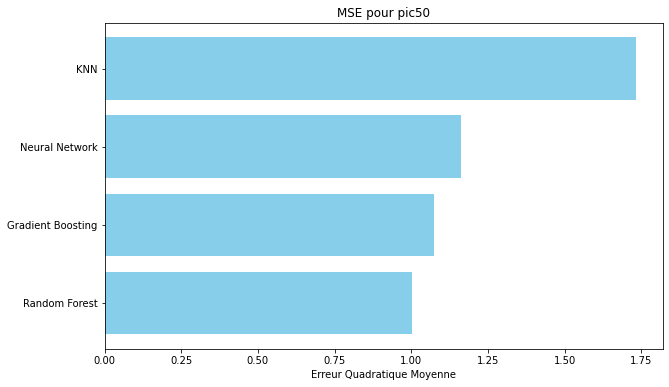

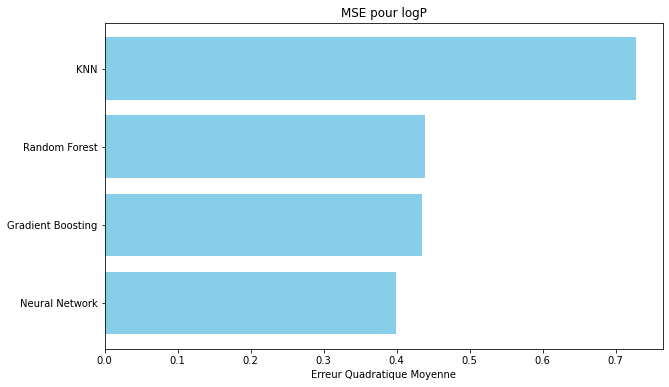

In [41]:
# Results visualization for mse pIC50, logP
plot_results(results_pic50_mse, "MSE pour pic50", "Erreur Quadratique Moyenne")
plot_results(results_logP_mse, "MSE pour logP", "Erreur Quadratique Moyenne")

### Root Mean Squared Error (RMSE)

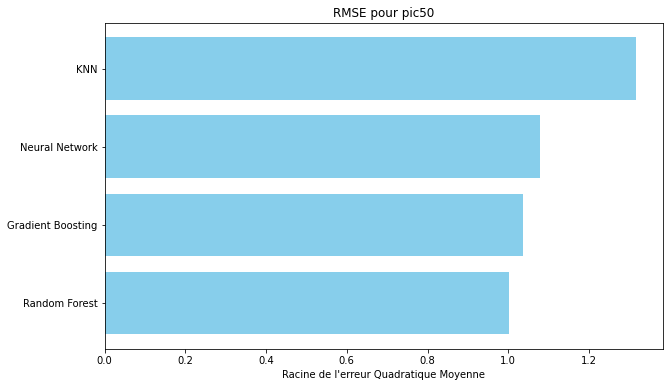

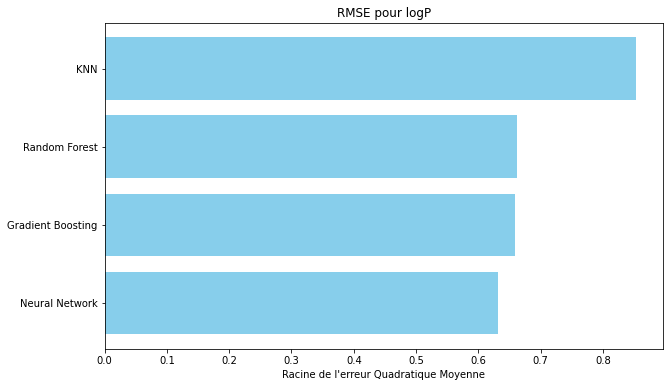

In [42]:
# Results visualization for rmse pIC50, logP
plot_results(results_pic50_rmse, "RMSE pour pic50", "Racine de l'erreur Quadratique Moyenne")
plot_results(results_logP_rmse, "RMSE pour logP", "Racine de l'erreur Quadratique Moyenne")

### Mean Absolute Error (MAE)

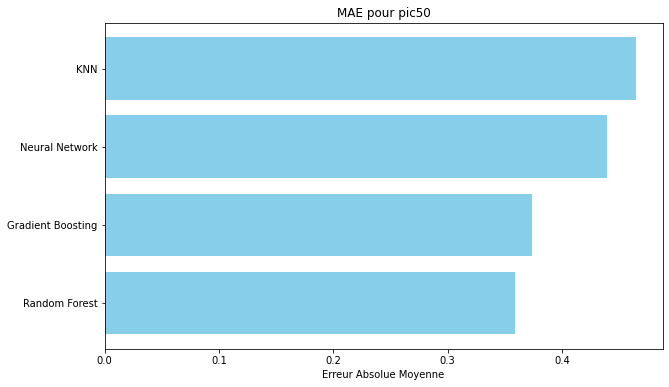

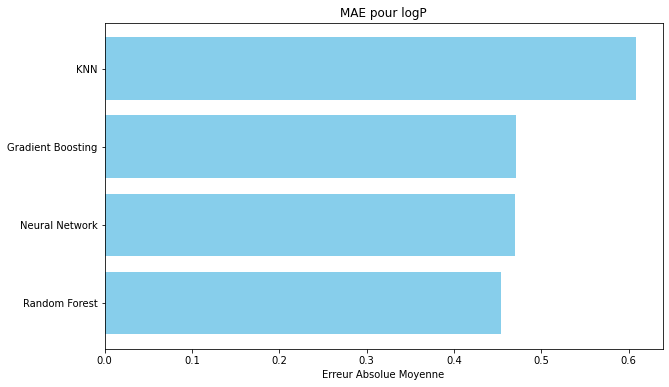

In [43]:
# Results visualization for mae pIC50, logP
plot_results(results_pic50_mae, "MAE pour pic50", "Erreur Absolue Moyenne")
plot_results(results_logP_mae, "MAE pour logP", "Erreur Absolue Moyenne")

### Mean Absolute Percentage Error (MAPE)

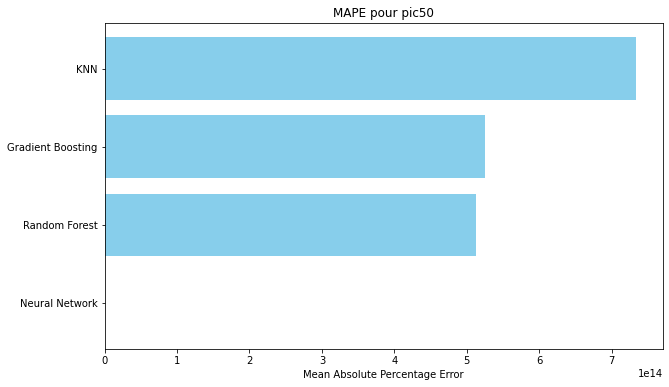

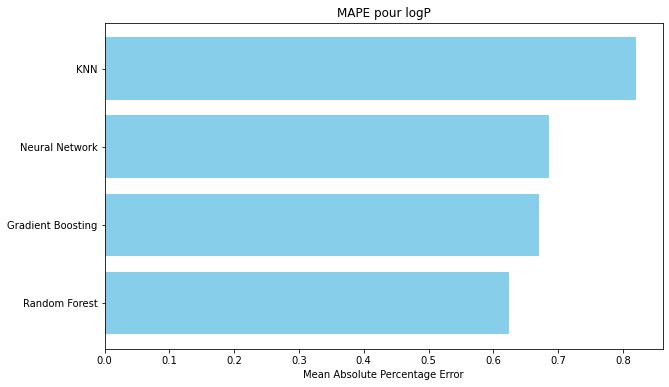

In [45]:
# Results visualization for mape pIC50, logP
plot_results(results_pic50_mape, "MAPE pour pic50", "Mean Absolute Percentage Error")
plot_results(results_logP_mape, "MAPE pour logP", "Mean Absolute Percentage Error")

In [33]:
# Visualize training processes for all models (pIC50)
# plot_multiple_training_processes(training_losses_pic50, validation_losses_pic50)


In [34]:
# Visualize training processes for all models (logP)
# plot_multiple_training_processes(training_losses_logP, validation_losses_logP)
